Import necessary libraries for data handling, plotting, the ARIMA and Prophet models and evaluation metrics.

In [2]:
# Run this code block to install required Python packages in your virtual environment
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get styles for the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries successfully imported")

Libraries successfully imported


Load data from avocado.csv into pandas.

In [2]:
try:
  df = pd.read_csv("avocado.csv")
  print("File loaded successfully")
except FileNotFoundError:
  print("Error: File not found")

File loaded successfully


Print data info

In [3]:
# Removing unnamed column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'], axis=1)

print('\n--- Data Info ---')
print(df.shape)

print('\n--- Data Head ---')
df.head()


--- Data Info ---
(18249, 13)

--- Data Head ---


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [5]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

## Data preprocessing for time series
We first have to convert the date into actual datetime objects, then sort the data by the date. We then filter the data into one single time series. We will use the reigon and type columns. First, we'll print the unique entries for each column.

In [6]:
if 'df' in locals():
  print('Regions \n')
  print(df['region'].unique())
  print('\n Types \n')
  print(df['type'].unique())

Regions 

['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']

 Types 

['conventional' 'organic']


We have TotalUS for the region which is all of the listed regions aggregated into one label. There are organic and conventional avocados sold. We will find which have a higher volume of sales and use that for a more stable and predictable time series.

In [7]:
if 'df' in locals():
  volume_comparison = df.groupby('type')['Total Volume'].sum()

  # Print volume_comparison as decimals to make it more readable
  total_sales = volume_comparison.sum()
  percentages = (volume_comparison / total_sales) * 100
  print("Total sales volume comparison")
  print(f'Conventional sales = {percentages.conventional:.2f}%')
  print(f'Organic sales = {percentages.organic:.2f}%')

Total sales volume comparison
Conventional sales = 97.19%
Organic sales = 2.81%


There are significantly more conventional avocados sold, so that will be our type for the time series.

In [8]:
if 'df' in locals():
  # Convert 'Date' into datetime objects
  df['Date'] = pd.to_datetime(df['Date'])

  # Sort the data by the date
  df.sort_values(by='Date', inplace=True)

  # Filter for single consistent time series
  region_filter = 'TotalUS'
  type_filter = 'conventional'

  ts_data = df[
      (df['region'] == region_filter) &
      (df['type'] == type_filter)].copy()

  # Set 'Date' as the index for the time series
  ts_data.set_index('Date', inplace=True)

  # We're interested in the AveragePrice
  ts_data = ts_data[['AveragePrice']]

  print(f'Time series data for {region_filter} ({type_filter})')
  print(ts_data.head())
  print(f'Time series data runs from ({ts_data.index.min()}) to ({ts_data.index.max()})')

Time series data for TotalUS (conventional)
            AveragePrice
Date                    
2015-01-04          0.95
2015-01-11          1.01
2015-01-18          1.03
2015-01-25          1.04
2015-02-01          0.89
Time series data runs from (2015-01-04 00:00:00) to (2018-03-25 00:00:00)


We will use the last 6 months as our test set to validate the ARIMA and Prophet models. A graph will be generated to visualize the split.

Training data from 2015-01-04 00:00:00 to 2017-10-05 (144)
Testing data from 2017-10-05 to 2018-03-25 00:00:00 (25)


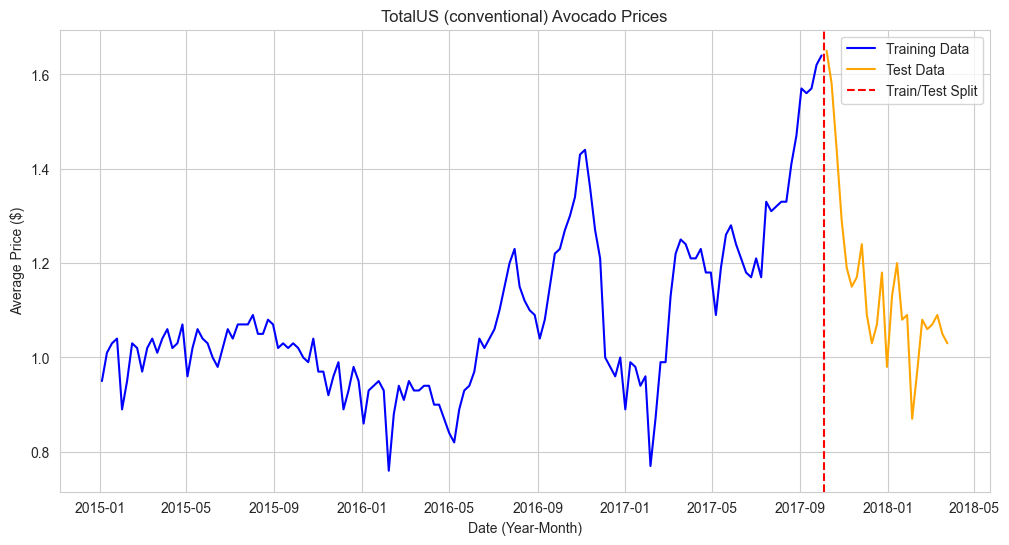

In [9]:
if 'df' in locals():
    split_date = '2017-10-05' # Example split date
    # convert split_date to a datetime so matplotlib can interpret it correctly
    split_dt = pd.to_datetime(split_date)

    train = ts_data[ts_data.index <= split_date]
    test = ts_data[ts_data.index > split_date]

    print(f'Training data from {ts_data.index.min()} to {split_date} ({len(train)})')
    print(f'Testing data from {split_date} to {ts_data.index.max()} ({len(test)})')

    # Visualize the split
    plt.figure(figsize=(12, 6))
    plt.title(f'{region_filter} ({type_filter}) Avocado Prices')
    plt.plot(train['AveragePrice'], label='Training Data', color='blue')
    plt.plot(test['AveragePrice'], label='Test Data', color='orange')
    plt.axvline(x=split_dt, color='red', linestyle='--', label='Train/Test Split')
    plt.xlabel('Date (Year-Month)')
    plt.ylabel('Average Price ($)')
    plt.legend()
    plt.show()

Prophet has a specific requirement, in that the date column must be named 'ds'
and the value column must be named 'y'.

In [10]:
# Reset index to get 'Date' back as a column
train_prophet = train.reset_index()
 # Rename columns to fit Prophet's requirements
train_prophet = train_prophet.rename(columns=
                     {'Date': 'ds', 
                      'AveragePrice': 'y'})
print('Prophet training data head:')
print(train_prophet.head())

Prophet training data head:
          ds     y
0 2015-01-04  0.95
1 2015-01-11  1.01
2 2015-01-18  1.03
3 2015-01-25  1.04
4 2015-02-01  0.89


The data is now set up. Now we will initialize the ARIMA and prophet models

## ARIMA model training

In [11]:
# ARIMA requires the time series to be stationary (constant mean and variance over time)
# We can use the Augmented Dickey-Fuller test to check for stationarity
# Null Hypothesis: The time series is non-stationary
# Alternative Hypothesis: The time series is stationary


if 'train' in locals():
    print("Checking for stationarity using Augmented Dickey-Fuller test:")
    
    adf_result = adfuller(train['AveragePrice'])
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')

    # Interpret the result
    if adf_result[1] <= 0.05:
        print("p-value is <= 0.05. The data is STATIONARY")
    else:
        print("p-value is > 0.05. The data is NON-STATIONARY")


Checking for stationarity using Augmented Dickey-Fuller test:
ADF Statistic: -0.8171130399881826
p-value: 0.8140434865067301
p-value is > 0.05. The data is NON-STATIONARY


The data should be non-stationary. In that case, we will need to find the order of differencing (d) to make it stationary.

In [12]:
# Set d = 1 for first-order differencing
print("Checking for stationarity after 1st difference (d = 1):")
train_diff1 = train['AveragePrice'].diff().dropna()

# Perform ADF test on differenced data
adf_result_diff1 = adfuller(train_diff1)

print(f'ADF Statistic (1st diff): {adf_result_diff1[0]}')
print(f'p-value (1st diff): {adf_result_diff1[1]}')
# Interpret the result
if adf_result_diff1[1] <= 0.05:
    print("p-value is <= 0.05. The differenced data is STATIONARY")
else:
    print("p-value is > 0.05. The differenced data is NON-STATIONARY")

Checking for stationarity after 1st difference (d = 1):
ADF Statistic (1st diff): -12.041155650675432
p-value (1st diff): 2.730248487242529e-22
p-value is <= 0.05. The differenced data is STATIONARY


Now the data should be stationary. Now we determine the p and q. The manual process requires manual analysis of PACF and ACF plots, but fortunately there is a library that can automatically find the best p and q for the model.

In [13]:
if 'train' in locals():
    print("Finding optimal p and q parameters using auto_arima...")
    # d is set to 1 based on previous ADF test results
    # m=52 for weekly data with yearly seasonality
    # seasonal=True to account for seasonality, and trace=True to print the progress

    auto_model_fit = auto_arima(
        train['AveragePrice'],
        start_p=0, max_p=3,
        start_q=0, max_q=3,
        m=52,
        d=1,
        seasonal=True,
        trace=True,
        stepwise=True,
        suppress_warnings=True,
    )
    print(f'Optimal parameters found: p={auto_model_fit.order[0]}, d={auto_model_fit.order[1]}, q={auto_model_fit.order[2]}')

Finding optimal p and q parameters using auto_arima...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=5.15 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-403.237, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-413.459, Time=6.74 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-416.014, Time=3.59 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-404.259, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-401.268, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=10.67 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=inf, Time=38.24 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=-413.459, Time=6.65 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=inf, Time=41.33 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=-417.846, Time=8.19 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=inf, Time=65.80 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=-415.450, Time=2.34 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=inf, Time

We now use the optimal p, d, and q values to train the model. The (0, 1, 0) is the non-seasonal order, and (0, 0, 1)[52] is the seasonal order. We can fit the model with and with out the seasonal order to see if it is necessary.

In [14]:
p = 0
d = 1
q = 0

if 'train' in locals():
    # For the ARIMA model without seasonal component
    arima_model = ARIMA(train['AveragePrice'], order=(p, d, q))

    arima_fit = arima_model.fit()

    # Print the model summary
    print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           AveragePrice   No. Observations:                  144
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 203.130
Date:                Sun, 23 Nov 2025   AIC                           -404.259
Time:                        17:31:26   BIC                           -401.296
Sample:                    01-04-2015   HQIC                          -403.055
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0034      0.000     11.373      0.000       0.003       0.004
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                30.61
Prob(Q):                              0.86   Pr

C:\Users\Hilario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Hilario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Hilario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [15]:
# Second model in a separate cell for better readability
p = 0  
d = 1
q = 0
m = 52

if 'train' in locals():
    # For seasonal ARIMA, we can set seasonal_order
    arima_model2 = ARIMA(train['AveragePrice'], order=(p, d, q), seasonal_order=(0, 0, 1, 52))

    # Fit the model
    arima_fit2 = arima_model2.fit()

    # Print the model summary
    print(arima_fit2.summary())

C:\Users\Hilario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Hilario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Hilario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Hilario\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       AveragePrice   No. Observations:                  144
Model:             ARIMA(0, 1, 0)x(0, 0, [1], 52)   Log Likelihood                 211.592
Date:                            Sun, 23 Nov 2025   AIC                           -419.184
Time:                                    17:31:43   BIC                           -413.258
Sample:                                01-04-2015   HQIC                          -416.776
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52       0.5506      0.134      4.111      0.000       0.288       0.813
sigma2         0.0027      0.000   

AIC measures the model fit with the number of parameters. Lower is better. BIC is similar but with a harsher penalty for complexity. Again, lower is better.
The Log likelihood measures how well the model overall fits the data. Higher is better. The model without the seasonal parameters had much more favorable results, implying that the seasonal results are not necessary. However, we shall compare the model without seasonal parameters versus the model with them to see how they compare.
Fun fact: The specific ARIMA model we've chosen (Arima(0, 1, 0)) is known as a "random walk model" which has zero autoregression and moving aggression terms, and one order of integration. It is a simpler model where the best prediction of the next value is the current value. In the case of avacado prices, random walk may be very efficient.

### Model forecast with ARIMA models


C:\Users\Hilario\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hilario\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


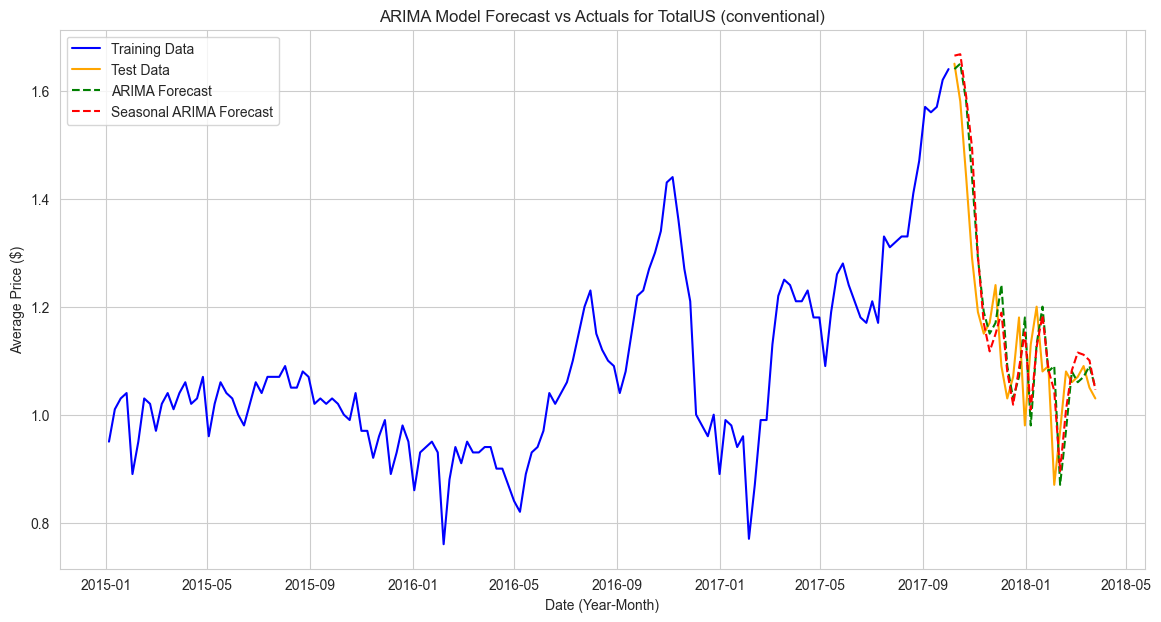

In [16]:
# Get number of observations in test set
n_periods_forecast = len(test)

# Generate predictions
#predictions1 = arima_fit.forecast(steps=n_periods_forecast)
#predictions2 = arima_fit2.forecast(steps=n_periods_forecast)
# Generate predictions using rolling forecast
predictions1 = []
history1 = train['AveragePrice'].tolist()
for t in range(n_periods_forecast):
    model = ARIMA(history1, order=(p, d, q))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions1.append(yhat)
    history1.append(test['AveragePrice'].iloc[t])
predictions2 = []
history2 = train['AveragePrice'].tolist()
for t in range(n_periods_forecast):
    model = ARIMA(history2, order=(p, d, q), seasonal_order=(0, 0, 1, 52))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions2.append(yhat)
    history2.append(test['AveragePrice'].iloc[t])

# Create a DataFrame for the predictions
forecast_df1 = pd.DataFrame(predictions1)
forecast_df1.index = test.index # Manually align index
forecast_df1.columns = ['Prediction']

forecast_df2 = pd.DataFrame(predictions2)
forecast_df2.index = test.index # Manually align index
forecast_df2.columns = ['Prediction']

# Plot the results
plt.figure(figsize=(14, 7))
plt.title(f'ARIMA Model Forecast vs Actuals for {region_filter} ({type_filter})')

# Plot training data
plt.plot(train['AveragePrice'], label='Training Data', color='blue')

# Plot test data
plt.plot(test['AveragePrice'], label='Test Data', color='orange')

# Plot forecasts
plt.plot(forecast_df1['Prediction'], label='ARIMA Forecast', color='green', linestyle='--')
plt.plot(forecast_df2['Prediction'], label='Seasonal ARIMA Forecast', color='red', linestyle='--')

plt.xlabel('Date (Year-Month)')
plt.ylabel('Average Price ($)')
plt.legend()
plt.show()


Both the base model (green dotted line) and seasonal model's (red dotted line) forecasts show a lot of correlation with the actual test data (orange solid line). The rolling forecasting appears to successfully allow the models to "shadow" the actual prices, capturing the volatility and nature of how the real world prices move.

Evaluating the ARIMA models

In [17]:
# The models' performances will be evaluated using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² metrics
print("Base ARIMA Model Performance on Test Set:")
mae = mean_absolute_error(test['AveragePrice'], forecast_df1['Prediction'])
rmse = np.sqrt(mean_squared_error(test['AveragePrice'], forecast_df1['Prediction']))
r2 = r2_score(test['AveragePrice'], forecast_df1['Prediction'])

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

print("\n")

print("Seasonal ARIMA Model Performance on Test Set:")
mae = mean_absolute_error(test['AveragePrice'], forecast_df2['Prediction'])
rmse = np.sqrt(mean_squared_error(test['AveragePrice'], forecast_df2['Prediction']))
r2 = r2_score(test['AveragePrice'], forecast_df2['Prediction'])

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Base ARIMA Model Performance on Test Set:
Mean Absolute Error (MAE): 0.0820
Root Mean Squared Error (RMSE): 0.1018
R² Score: 0.6646


Seasonal ARIMA Model Performance on Test Set:
Mean Absolute Error (MAE): 0.0788
Root Mean Squared Error (RMSE): 0.0949
R² Score: 0.7084


MAE is the average absolute difference between predicted and actual prices. The base model was off by about 8.2 cents, and the seasonal model was off by about 10 cents.

RMSE is similar to MAE but penalizes larger errors more. The base RMSE says the model is off by 10 cents, which is close to the base MAE's 8.2. This suggests the model is highly accurate and consistent, the seasonal RMSE ranks at about 9.4 cents, compared to the seasonal MAE's 10. The seasonal model is more slightly more consistent.

R-squared is the proportion of predictable variance in avocado prices. 1.0 is a perfect prediction, and 0.0 is about the same as predicting the average price, and a negative value means the model is worse than that. Both models scored poorly, but the seasonal model's score of 0.6646 is better than the base model's 0.7084.

The results show that the seasonal parameters in this case have shown an improvement to the model's performance, which proves that the data is more complex than a random walk. The scores for Seasonal ARIMA is slightly higher than the base ARIMA model for evidence.

The following is the set up for the Prophet model, one that is much more complex and built for predicting future prices, trends, and holiday seasons.

## Prophet model training

The plan is to initialize Prophet and specify weekly/yearly seasonality. We fit the model with the 'train_prophet' DataFrame we set up earlier, then create a "future" DataFrame to make predictions with. Finally we will generate the forecast and evaluate the results.

In [18]:

prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=True)

prophet_model.fit(train_prophet)

print("Prophet model fitted successfully.")

17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted successfully.


In [19]:
future_df = prophet_model.make_future_dataframe(periods=len(test), freq='W-SUN') # Frequency set to weekly ending on Sundays
print("Future dataframe for Prophet created successfully.")

Future dataframe for Prophet created successfully.


In [20]:
forecast = prophet_model.predict(future_df)
print("Forecast generated successfully.")

Forecast generated successfully.


Plotting Prophet forecast


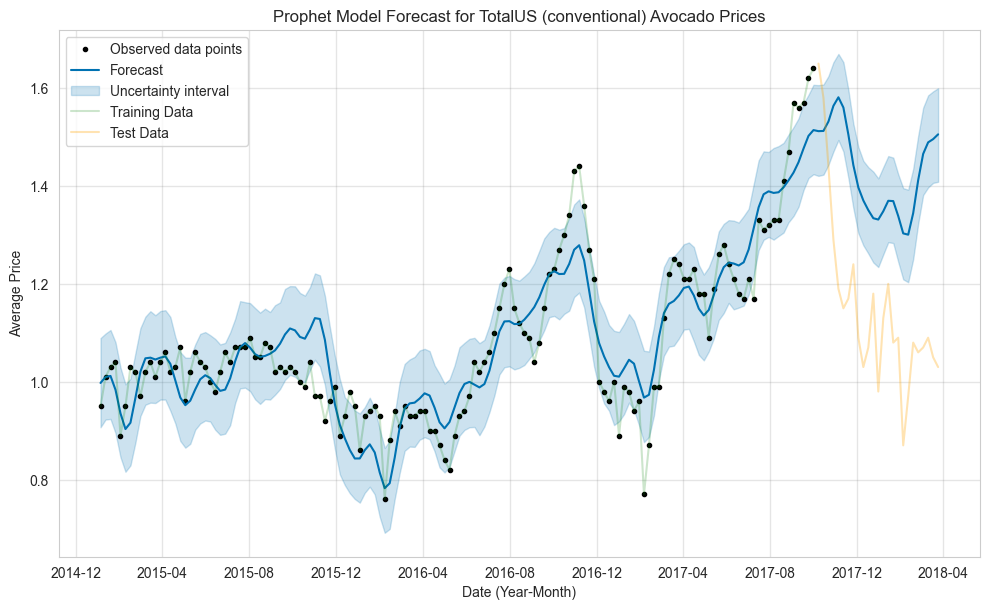

In [21]:
print("Plotting Prophet forecast")
fig1 = prophet_model.plot(forecast)
plt.title(f'Prophet Model Forecast for {region_filter} ({type_filter}) Avocado Prices')
# Plot training data for comparison
plt.plot(train['AveragePrice'], label='Training Data', color='green', alpha=0.2)
# Plot test data for comparison
plt.plot(test['AveragePrice'], label='Test Data', color='orange', alpha=0.3)
plt.xlabel('Date (Year-Month)')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [22]:
# Get predictions for the test period
predictions_prophet = forecast[forecast['ds'].isin(test.index)]['yhat']

# Compare with test set
actuals_prophet = test['AveragePrice']

print("Prophet model performance on Test Set:")
mae = mean_absolute_error(actuals_prophet, predictions_prophet)
rmse = np.sqrt(mean_squared_error(actuals_prophet, predictions_prophet))
r2 = r2_score(actuals_prophet, predictions_prophet)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Prophet model performance on Test Set:
Mean Absolute Error (MAE): 0.2946
Root Mean Squared Error (RMSE): 0.3143
R² Score: -2.1978


Despite Prophet being tailor-made for handling trends and seasonality, it wound up performing worse than both of the ARIMA and seasonal ARIMA models. One possibility is because of Prophet's default forecasting method being static, as in it predicted all 25 weeks at once. It winds up performing worse than simply taking the average price of all the testing data. On the other hand, the ARIMA models used a rolling forecasting method that predicts one week at a time. Although it is more complex, it is possible to perform a rolling forecast on Prophet for a more accurate comparison.

First, we will need a new model that will be repeatedly trained weekly throughout the testing period. The predictions and actual results will be stored in their own lists and 

In [23]:
prophet_predictions_rolling = [] # Store rolling predictions
prophet_actuals_rolling = [] # Store actuals

for i in range (len(test)):
    # Get the current test step
    current_test_step = test.iloc[i:i+1]

    # Initialize and fit a new Prophet model
    prophet_model_rolling = Prophet(weekly_seasonality=True, seasonality_mode='multiplicative')
    prophet_model_rolling.fit(train_prophet)

    # Create a future dataframe for predictions and generate the forecast
    future_df = prophet_model_rolling.make_future_dataframe(periods=1, freq='W-SUN') # W-SUN for weekly data ending on Sundays
    forecast = prophet_model_rolling.predict(future_df)

    # Get the one-step ahead prediction
    predictions_one_step = forecast.iloc[-1]['yhat']

    # Store the prediction and actual value
    prophet_predictions_rolling.append(predictions_one_step)
    prophet_actuals_rolling.append(current_test_step['AveragePrice'].values[0])

    # Update the training data by adding the current test step
    new_history_row = current_test_step.reset_index().rename(columns={'Date': 'ds', 'AveragePrice': 'y'})
    train_prophet = pd.concat([train_prophet, new_history_row], ignore_index=True)

print("Prophet rolling forecast complete.")

17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1]

Prophet rolling forecast complete.


Plotting Prophet forecast


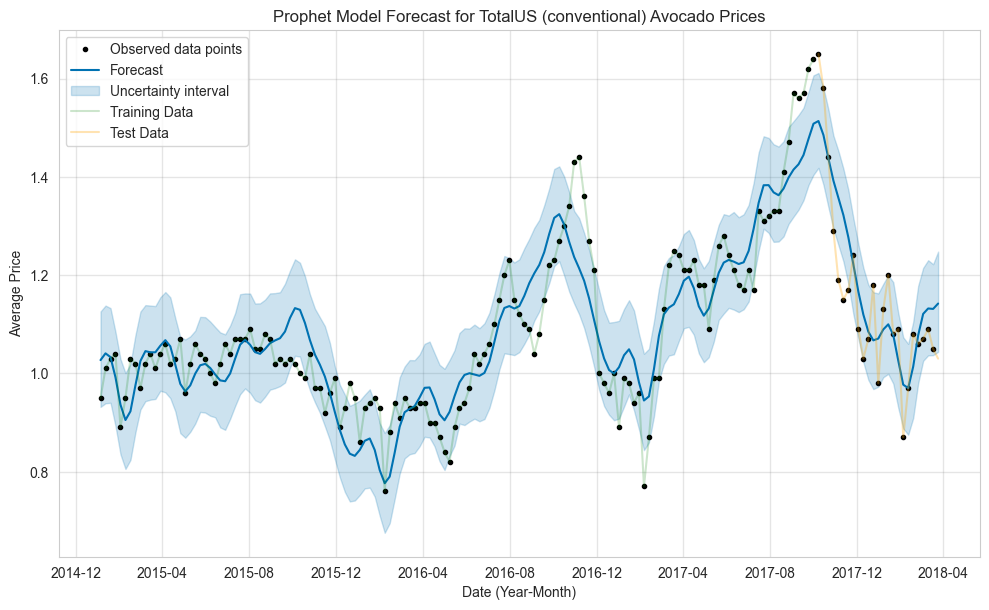

In [24]:
print("Plotting Prophet forecast")
fig1 = prophet_model_rolling.plot(forecast)
plt.title(f'Prophet Model Forecast for {region_filter} ({type_filter}) Avocado Prices')
# Plot training data for comparison
plt.plot(train['AveragePrice'], label='Training Data', color='green', alpha=0.2)
# Plot test data for comparison
plt.plot(test['AveragePrice'], label='Test Data', color='orange', alpha=0.3)
plt.xlabel('Date (Year-Month)')
plt.ylabel('Average Price')
plt.legend()
plt.show()

With Prophet, it produces its own forecast plot. The black dots represent the actual, historical data points that the model learned from. This is represented by the training data line tracing through those points exactly, up until the split where there are no more dots. 

The blue line represents the model's forecast. From 2015 to the data split in 2017, the line shows how well the model fits into the training data, and capturing the overall trend. From the data split and onwards, it's the actual forecast, or the model's prediction for the future. 

The light-blue shaded area is the uncertainty interval, representing the range of values the model thinks the price could fall into.

In [25]:

print("Prophet model performance on Test Set:")
mae = mean_absolute_error(prophet_actuals_rolling, prophet_predictions_rolling)
rmse = np.sqrt(mean_squared_error(prophet_actuals_rolling, prophet_predictions_rolling))
r2 = r2_score(prophet_actuals_rolling, prophet_predictions_rolling)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Prophet model performance on Test Set:
Mean Absolute Error (MAE): 0.1234
Root Mean Squared Error (RMSE): 0.1570
R² Score: 0.2022


As the results show, Prophet wound up performing the worst out of the models, even when using the same rolling forecast method as the ARIMA models. This rolling version of the model itself did do a good job in giving a generalized prediction, however it is possibly overfitted for the data we have. The Prophet model is much more complex and is designed to look at the overall bigger picture, taking seasonality, holidays, and trends into account. With us using a period of one week per prediction however, it would repeatedly try to find the best possible trends or seasonality, which was unnecessary for weekly predictions.

As for the original static version, it had likely suffered from concept drift. Concept drift is where the model's input data and target variables change over time, potentially damaging the quality of the model's predictions. In our case, there was a sharp shift in the test set that the model couldn't accurately predict. The model did predict a seasonal downward shift based on the training, but not the actual magnitude of the drop. This may be because of a sharp trend reversal that the model could not have predicted.

The key take away is that for our data set and task of predicting avocado prices weekly, the both the ARIMA models performed the best, with the Seasonal ARIMA model specifically coming out on top. ARIMA is the simpler, more reactive model of the two, while Prophet was too complex in this task. Prophet may perform better in longer-term predictions like it is built for, as in several months or even years, while also predicting seasonal trends that ARIMA cannot.